In [2]:
!rm -r ../root/.kaggle
!mkdir ../root/.kaggle
!cp kaggle.json ../root/.kaggle
!chmod 600 ../root/.kaggle/kaggle.json
!rm -r sample_data
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=bf187f2821eb28440af51051fb3ad361f9750358f4be50775066a9b6244b5a99
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [3]:
!kaggle datasets download umangjpatel/pap-smear-datasets --unzip
!rm -r herlev_pap_smear
!rm -r sipakmed_fci_pap_smear

100% 6.44G/6.44G [02:18<00:00, 38.9MB/s]
100% 6.44G/6.44G [02:18<00:00, 49.9MB/s]


In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import efficientnet
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold

In [5]:
path = Path(".")
path.ls()

[PosixPath('.config'),
 PosixPath('kaggle.json'),
 PosixPath('sipakmed_wsi_pap_smear')]

In [6]:
data_init = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (966 items)
x: ImageList
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048)
y: CategoryList
abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic
Path: sipakmed_wsi_pap_smear;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: sipakmed_wsi_pap_smear;

Test: None

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

In [0]:
!mkdir sipakmed_wsi_pap_smear/models

In [0]:
def model_callback(model, model_name):
  return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [0]:
def find_appropriate_lr(model, lr_diff = 15, loss_threshold = .05, adjust_value = 1, plot = True):
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [11]:
i = 0
with gpu_mem_restore_ctx():
  model_name = input("Enter the model name : ")
  for train_idx, valid_idx in skf.split(data_init.x.items, data_init.y.items):
    print("&*" * 50)
    print(f"FOLD-{i}")
    fold_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
                .split_by_idxs(train_idx, valid_idx)
                .label_from_folder()
                .transform(get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=0.50), size=224)
                .databunch()
                .normalize(imagenet_stats))
    if i == 0:
      learner = cnn_learner(fold_data, models.resnet34, metrics=[accuracy, Precision(), Recall(), FBeta(beta=1), KappaScore(weights="quadratic")]).to_fp16()
    else:
      load_name = model_name + f"-stage2-fold{i-1}"
      learner.purge()
      learner.load(load_name)
    stage1_name = model_name + f"-stage1-fold{i}"
    learner.fit_one_cycle(20, max_lr=slice(1e-03, 1e-02), callbacks=model_callback(learner, stage1_name))
    learner.load(stage1_name)
    learner.unfreeze()
    stage2_name = model_name + f"-stage2-fold{i}"
    learner.fit_one_cycle(10, max_lr=slice(1e-06, 1e-05), callbacks=model_callback(learner, stage2_name))
    i += 1
    print("&*" * 50)

Enter the model name : best-rn34-sipak
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*
FOLD-0


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Better model found at epoch 0 with accuracy value: 0.6397515535354614.


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with accuracy value: 0.8074533939361572.
Better model found at epoch 2 with accuracy value: 0.8136646151542664.
Better model found at epoch 3 with accuracy value: 0.8322981595993042.
Better model found at epoch 5 with accuracy value: 0.850931704044342.
Better model found at epoch 6 with accuracy value: 0.8695651888847351.
Better model found at epoch 7 with accuracy value: 0.8819875717163086.
Better model found at epoch 8 with accuracy value: 0.8850931525230408.
Better model found at epoch 9 with accuracy value: 0.8975155353546143.
Better model found at epoch 10 with accuracy value: 0.9006211161613464.
Better model found at epoch 13 with accuracy value: 0.909937858581543.
Better model found at epoch 14 with accuracy value: 0.9161490797996521.


Better model found at epoch 0 with accuracy value: 0.9130434989929199.
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*
FOLD-1


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.782608687877655.
Better model found at epoch 7 with accuracy value: 0.8385093212127686.
Better model found at epoch 8 with accuracy value: 0.8540372848510742.
Better model found at epoch 11 with accuracy value: 0.8850931525230408.
Better model found at epoch 12 with accuracy value: 0.9192546606063843.
Better model found at epoch 13 with accuracy value: 0.9223602414131165.
Better model found at epoch 17 with accuracy value: 0.9285714030265808.
Better model found at epoch 19 with accuracy value: 0.9316770434379578.


Better model found at epoch 0 with accuracy value: 0.9316770434379578.
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*
FOLD-2


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.9223602414131165.
Better model found at epoch 15 with accuracy value: 0.9285714030265808.
Better model found at epoch 16 with accuracy value: 0.9316770434379578.


Better model found at epoch 0 with accuracy value: 0.9347826242446899.
Better model found at epoch 5 with accuracy value: 0.9378882050514221.
&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*&*


In [12]:
full_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_none()
            .label_from_folder()
            .transform(get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=0.50), size=224)
            .databunch()
            .normalize(imagenet_stats))
full_data

ImageDataBunch;

Train: LabelList (966 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic
Path: sipakmed_wsi_pap_smear;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: sipakmed_wsi_pap_smear;

Test: None

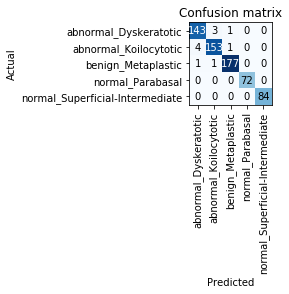

In [13]:
learner.load("best-rn34-sipak-stage2-fold2")
interp = ClassificationInterpretation.from_learner(learner, ds_type=DatasetType.Train)
interp.plot_confusion_matrix(figsize=(7, 7))

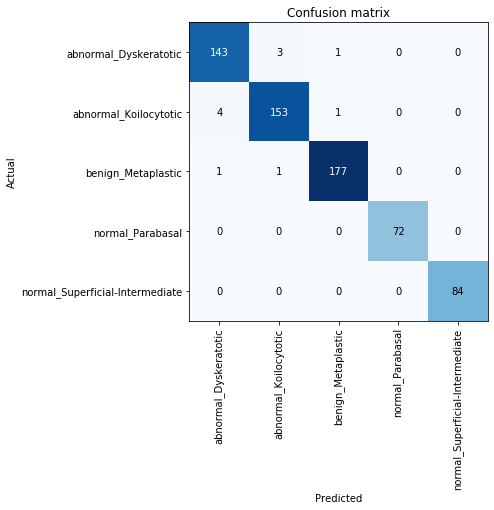

In [14]:
interp.plot_confusion_matrix(figsize=(7, 7))

In [17]:
learner_32 = to_fp32(learner)
learner_32.validate(dl=full_data.train_dl, metrics=[accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(beta=1, average="macro"), KappaScore(weights="quadratic")])

[0.106774084,
 tensor(0.9656),
 tensor(0.9719),
 tensor(0.9727),
 tensor(0.9722),
 tensor(0.9819)]